In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 10})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Wrapping Pathway A for ease of use

### Load adjacency

In [2]:
# directory where data is stored
datadir = "/Users/lindenmp/Google-Drive-Rutgers/work/research_projects/nctpy/data"
resultsdir = "/Users/lindenmp/Google-Drive-Rutgers/work/research_projects/nctpy/results"
adjacency_file = "pnc_schaefer200_Am.npy"

In [3]:
# load A matrix
adjacency = np.load(os.path.join(datadir, adjacency_file))
n_nodes = adjacency.shape[0]
print(adjacency.shape)

(200, 200)


### Get states

In [4]:
# load node-to-system mapping
system_labels = list(
    np.loadtxt(os.path.join(datadir, "pnc_schaefer200_system_labels.txt"), dtype=str)
)

In [5]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [6]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

### Setup control tasks

In [7]:
# initialize list of control tasks
control_tasks = []

# define control set using a uniform full control set
# note, here we use the same control set for all control tasks
control_set = np.eye(n_nodes)

# define state trajectory constraints
# note, here we constrain the full state trajectory equally for all control tasks
trajectory_constraints = np.eye(n_nodes)

# define mixing parameter
# note, here we use the same rho for all control tasks
rho = 1

# assemble control tasks
n_states = len(state_labels)
for initial_idx in np.arange(n_states):
    initial_state = normalize_state(states == initial_idx)  # initial state
    for target_idx in np.arange(n_states):
        target_state = normalize_state(states == target_idx)  # target state

        control_task = dict()  # initialize dict
        control_task["x0"] = initial_state  # store initial state
        control_task["xf"] = target_state  # store target state
        control_task["B"] = control_set  # store control set
        control_task["S"] = trajectory_constraints  # store state trajectory constraints
        control_task["rho"] = rho  # store rho
        control_tasks.append(control_task)

### Run ComputeControlEnergy

In [8]:
# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(
    A=adjacency, control_tasks=control_tasks, system="continuous", c=1, T=1
)
compute_control_energy.run()

100%|██████████| 49/49 [00:05<00:00,  8.39it/s]


### Plot energy matrices

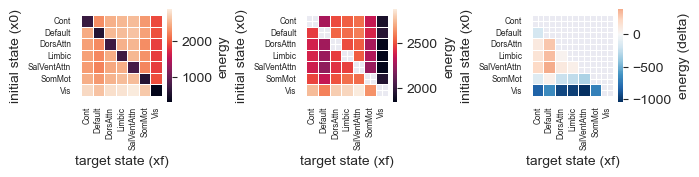

In [9]:
# reshape energy into matrix
energy_matrix = np.reshape(compute_control_energy.E, (n_states, n_states))

# subtract lower triangle from upper to examine energy asymmetries
energy_matrix_delta = energy_matrix.transpose() - energy_matrix

f, ax = plt.subplots(1, 3, figsize=(7, 4))

# plot energy matrix
sns.heatmap(
    energy_matrix,
    ax=ax[0],
    square=True,
    linewidth=0.5,
    cbar_kws={"label": "energy", "shrink": 0.25},
)

# plot without self-transitions
# setup mask to exclude persistence energy (i.e., transitions where i==j)
mask = np.zeros_like(energy_matrix)
mask[np.eye(n_states) == 1] = True
sns.heatmap(
    energy_matrix,
    ax=ax[1],
    square=True,
    linewidth=0.5,
    cbar_kws={"label": "energy", "shrink": 0.25},
    mask=mask,
)

# plot energy asymmetries
mask = np.triu(np.ones_like(energy_matrix, dtype=bool))
sns.heatmap(
    energy_matrix_delta,
    ax=ax[2],
    square=True,
    linewidth=0.5,
    cbar_kws={"label": "energy (delta)", "shrink": 0.25},
    mask=mask,
    cmap="RdBu_r",
    center=0,
)

for cax in ax:
    cax.set_ylabel("initial state (x0)")
    cax.set_xlabel("target state (xf)")
    cax.set_yticklabels(state_labels, rotation=0, size=6)
    cax.set_xticklabels(state_labels, rotation=90, size=6)
f.tight_layout()
f.savefig(
    os.path.join(resultsdir, "energy_matrix.svg"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()